In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from evaluate_util import sds_file_handling, plot_haus_mean_comparison, plot_dice_mean_comparison, plot_cdr_mae_mean_comparison
from evaluate_util import plot_dice_violin_comparison, plot_haus_violin_comparison, plot_cdr_mae_violin_comparison

# check out https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.errorbar.html#matplotlib.axes.Axes.errorbar
# for plot of numerous experiments with same settings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# percentages, dice_dic, haus_dic, cdr_dic = sds_file_handling(exp_path)
# whole_dice = np.array([dice_dic[percentages[i]] for i in range(percentages.shape[0])]).squeeze()
# whole_haus = np.array([haus_dic[percentages[i]] for i in range(percentages.shape[0])]).squeeze()

In [10]:
# print(whole_dice.shape)
# print(whole_haus.shape)

In [11]:
# alpha = 0.05  # alpha level for confidence intervals
# 
# plt.errorbar(percentages,
#              whole_dice.mean(axis=2)[:, 1],
#              linestyle="-", color="b", label="disc performance")
# plt.errorbar(percentages,
#              whole_dice.mean(axis=2)[:, 0],
#              linestyle="--", color="cornflowerblue", label="cup performance")
# # plt.plot(percentages, disc_performance, linestyle="-", color="b", label="disc performance")
# # plt.plot(percentages, cup_performance, linestyle="--", color="b", label="cup performance")
# plt.xlabel("fraction of used training data")
# plt.ylabel("dice score")
# plt.legend()

In [12]:
# alpha = 0.05  # alpha level for confidence intervals
# 
# plt.errorbar(percentages,
#              whole_haus.mean(axis=2)[:, 1],
#              linestyle="-", color="b", label="disc performance")
# plt.errorbar(percentages,
#              whole_haus.mean(axis=2)[:, 0],
#              linestyle="--", color="cornflowerblue", label="cup performance")
# # plt.plot(percentages, disc_performance, linestyle="-", color="b", label="disc performance")
# # plt.plot(percentages, cup_performance, linestyle="--", color="b", label="cup performance")
# plt.xlabel("fraction of used training data")
# plt.ylabel("hausdorff distance")
# plt.legend()

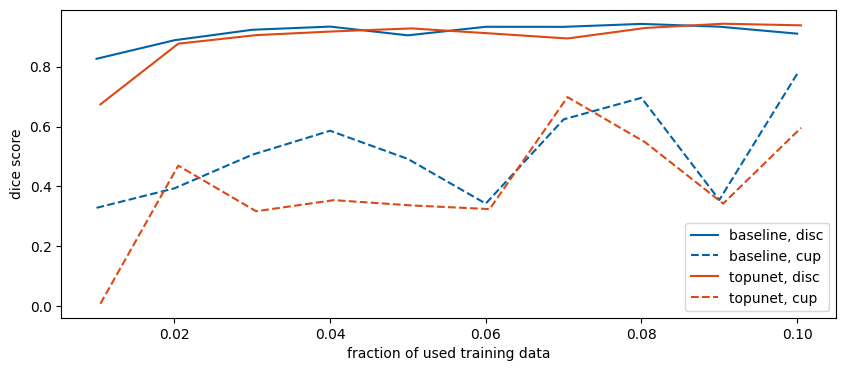

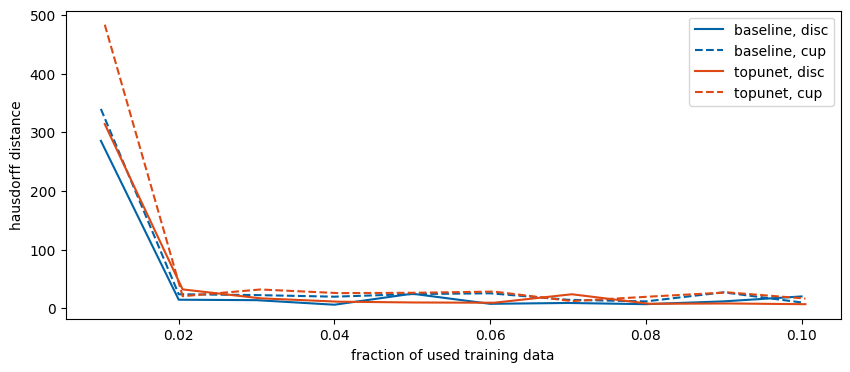

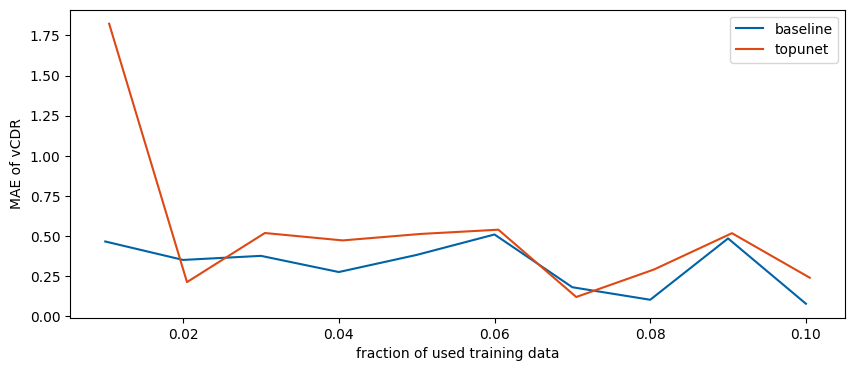

In [13]:
experiments_of_interest = ["standard", "naivetop_V3"]
experiments_labels = ["baseline", "topunet", "polar"]

plot_dice_mean_comparison(experiments_of_interest, experiments_labels)
plot_haus_mean_comparison(experiments_of_interest, experiments_labels)
plot_cdr_mae_mean_comparison(experiments_of_interest, experiments_labels)

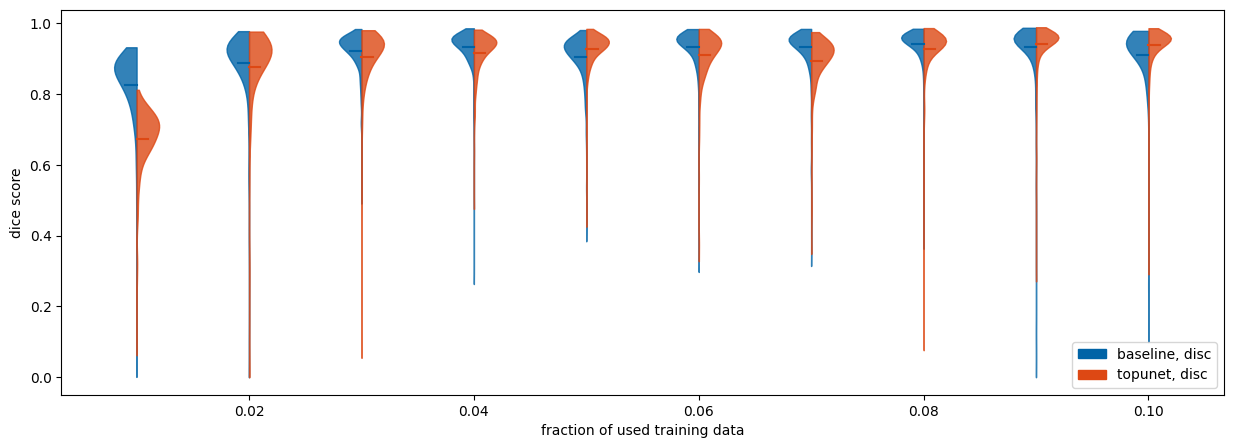

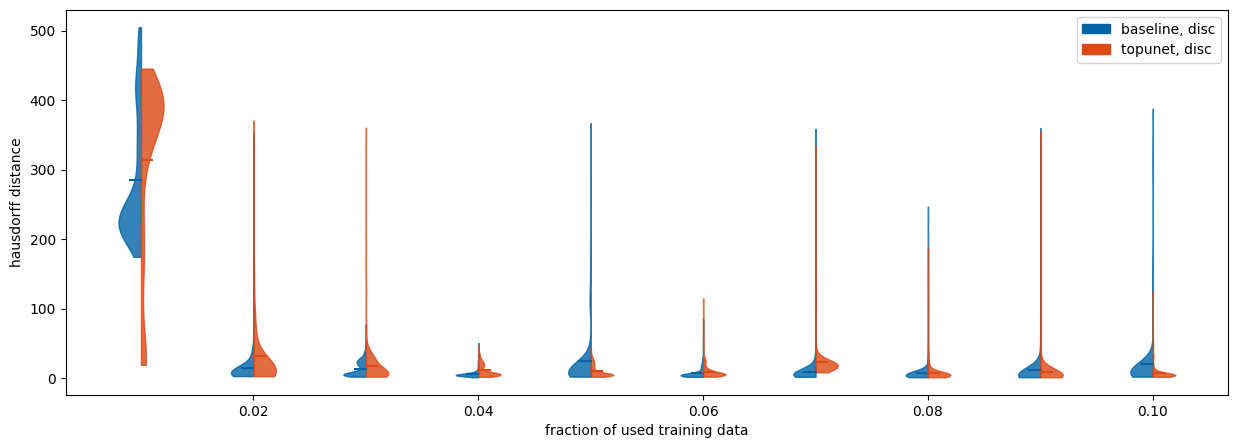

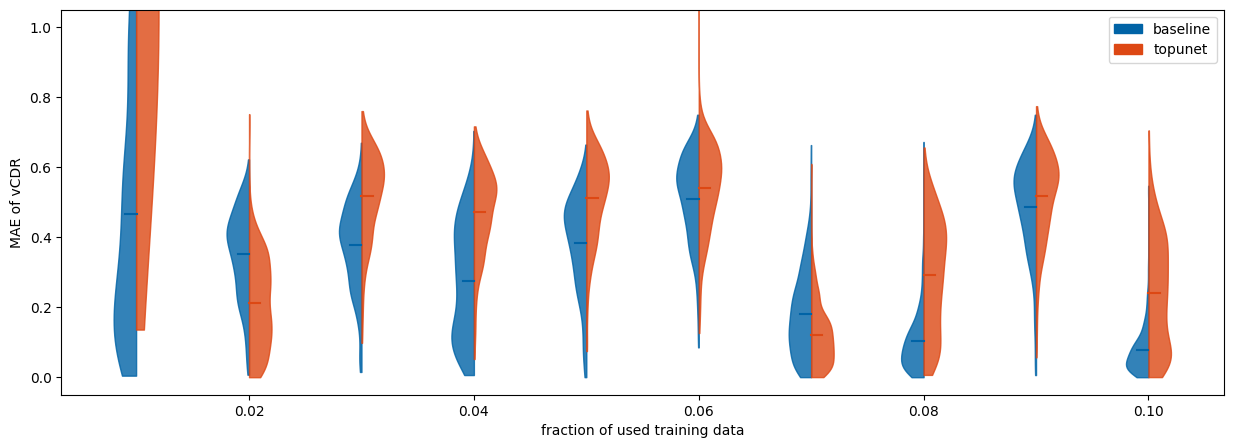

In [14]:
plot_dice_violin_comparison(experiments_of_interest, experiments_labels, show_means=True, show_cup=False)
plot_haus_violin_comparison(experiments_of_interest, experiments_labels, show_means=True, show_cup=False)
plot_cdr_mae_violin_comparison(experiments_of_interest, experiments_labels, show_means=True)